## Introduction
This note notebook contains code for the CNN model that was used to predict cognitive load level. I used the same archtecture for all datasets and features explained in the report. This particular model was trained on topomap images dataset topomap images resulting from stacking the horizontally stacked frequecy bands topomap from three time intervals of the working meory's encoding stage period.

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels

from vis.utils import utils
from keras import activations

Using TensorFlow backend.


## Loading and preprocessing the data
The dataset has 44,000 images from four cognitive load levels( 4 classes) with 11,000 images per each level. I split the data into training and testing
using 70-30% ratio for training and testing respectively. Dataset contains colored images(3-channel) were resize to the the (224,224,3) dimension.

In [2]:
#### from __future__ import print_function


num_classes = 4
img_rows, img_cols = 224,224
batch_size =16
train_data_dir = './data/train'
validation_data_dir = './data/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator()
#rescale=1./255)
validation_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
nb_train_samples = 29328
nb_validation_samples = 14672


Found 29328 images belonging to 4 classes.
Found 14672 images belonging to 4 classes.


In [3]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1. 1. 1. 1.]


## Confusion matrix
plot_confusion_matrix function returns confusion matrix in image form.

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = ''
        else:
            title = ''
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.savefig(name, dpi = 1200)
    return ax

## Let's create our Model
The model has six consective convolution and Max-pooling layers followed by one Fully connected layer and softmax layer

In [5]:
model = Sequential()

# First CONV-ReLU Layer
model.add(Conv2D(32, (7, 7), padding = 'same', input_shape = (img_rows, img_cols,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second CONV-ReLU Layer
model.add(Conv2D(64, (5, 5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))


# Final Dense Layer
model.add(Dense(num_classes,activation='softmax',name='mbm'))

print(model.summary())

W1003 16:54:10.927000 139845451548480 deprecation_wrapper.py:119] From /home/cvpia-admin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1003 16:54:10.938775 139845451548480 deprecation_wrapper.py:119] From /home/cvpia-admin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1003 16:54:10.940473 139845451548480 deprecation_wrapper.py:119] From /home/cvpia-admin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1003 16:54:10.956944 139845451548480 deprecation_wrapper.py:119] From /home/cvpia-admin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
__________

In [6]:
%matplotlib inline
plot_model(model, to_file='LittleVGG.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('LittleVGG.png')
plt.figure(figsize=(100,70))
plt.show()

<Figure size 7200x5040 with 0 Axes>

### Training our Model
Our model was trained over 100 epochs with batch size of 16. I used two callbacks,checkpoints,earlystopping,andReduceLRonPlateau( reduce learning rate on plateau) to monitor the training process. Checkpoint check whether testing accuracy is increasing or decreasing after each epoch and only saves the best model. Early stoppping stops trained when accuracy is no longer improving and a set value of epochs. ReducLRonPlateau rreduces learning rate to help the model learn better when accuracy is not improving

In [7]:
             
checkpoint = ModelCheckpoint("./model/cnn_topomap-weights--2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics = ['accuracy'])


epochs = 100

history= model.fit_generator(   
    
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

W1003 16:54:13.012948 139845451548480 deprecation_wrapper.py:119] From /home/cvpia-admin/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1003 16:54:13.094163 139845451548480 deprecation.py:323] From /home/cvpia-admin/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
1833/1833 [==============================] - 72s 39ms/step - loss: 4.9624 - acc: 0.5829 - val_loss: 5.3220 - val_acc: 0.4221

Epoch 00001: val_loss improved from inf to 5.32201, saving model to ./model/cnn_topomap-weights--2.h5
Epoch 2/100
1833/1833 [==============================] - 69s 37ms/step - loss: 2.4255 - acc: 0.8355 - val_loss: 2.2162 - val_acc: 0.7423

Epoch 00002: val_loss improved from 5.32201 to 2.21618, saving model to ./model/cnn_topomap-weights--2.h5
Epoch 3/100
1833/1833 [==============================] - 69s 38ms/step - loss: 1.4203 - acc: 0.9050 - val_loss: 1.4437 - val_acc: 0.8121

Epoch 00003: val_loss improved from 2.21618 to 1.44368, saving model to ./model/cnn_topomap-weights--2.h5
Epoch 4/100
1833/1833 [==============================] - 68s 37ms/step - loss: 0.9652 - acc: 0.9315 - val_loss: 0.9043 - val_acc: 0.9053

Epoch 00004: val_loss improved from 1.44368 to 0.90431, saving model to ./model/cnn_topomap-weights--2.h5
Epoch 5/100
1833/1833 [=====

In [8]:
model.save("./model/cnn_topomap--2.h5")


## Performance Analysis
Below I show classification perfomance of the model with confusion matrix,classificaion report, training , and testing curves.

Found 14672 images belonging to 4 classes.
Confusion Matrix
[[3595   29   17   27]
 [  19 3550    9   90]
 [  13   15 3626   14]
 [  30   60   21 3557]]
Classification Report
              precision    recall  f1-score   support

         cl2       0.98      0.98      0.98      3668
         cl4       0.97      0.97      0.97      3668
         cl6       0.99      0.99      0.99      3668
         cl8       0.96      0.97      0.97      3668

    accuracy                           0.98     14672
   macro avg       0.98      0.98      0.98     14672
weighted avg       0.98      0.98      0.98     14672

Confusion matrix, without normalization
[[3595   29   17   27]
 [  19 3550    9   90]
 [  13   15 3626   14]
 [  30   60   21 3557]]
Normalized confusion matrix
[[0.98009815 0.00790622 0.00463468 0.00736096]
 [0.00517993 0.96782988 0.00245365 0.02453653]
 [0.00354417 0.00408942 0.98854962 0.00381679]
 [0.00817884 0.01635769 0.00572519 0.96973828]]


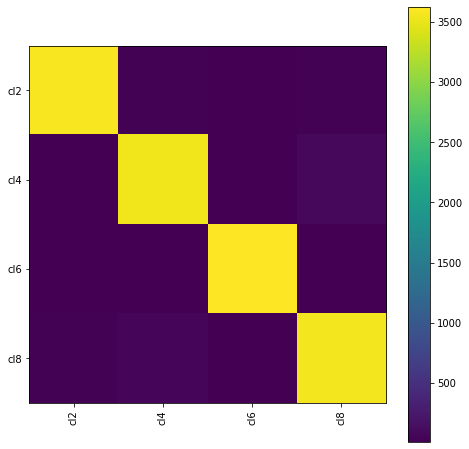

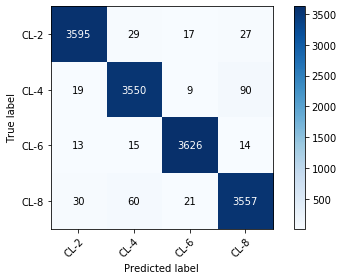

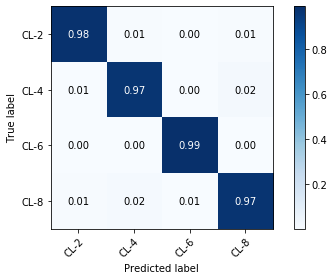

In [9]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
nb_train_samples = 29328
nb_validation_samples = 14672


#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

class_names=np.asarray(['CL-2','CL-4','CL-6','CL-8'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names,title='',name='conf_matrix')
# Plot normalized confusion matrix
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names, normalize=True,title='',name='conf_matrix_Nor')
plt.show()


### Plotting our Accuracy and Loss Charts

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


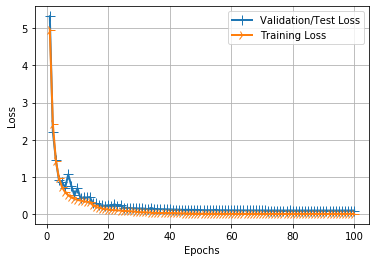

In [10]:

print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss.png', dpi = 1200)
plt.show()

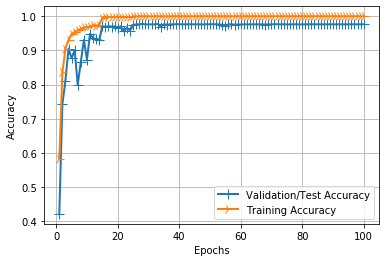

In [11]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('Accuracy.png', dpi = 1200)
plt.show()